# High Dynamic Range (HDR)

## Capture
The (digital) sensor of a camera is only able to measure accurately within a certain luminance range. This range can change between photos but it limits the *dynamic range* of a single picture. Taking a picture with the sun in the background for example will often result in pitch black shadows without any detail.
![HDR capture](https://cdn-files.cloud/wp-content/blogs.dir/68/files/2017/08/smartphone-camera-tips-HDR.jpg)
You might have noticed that your smartphone's camera app has a HDR button. With this mode enabled it will take multiple pictures at different exposure levels (which shifts the luminance range that the camera is able to capture) and use clever algorithms to combine them together. Similar results can also be achieved with a DLSR by taking multiple photos and using computer software to combine them into a single image. Although digital cinema camera have a large dynamic range by their own, some of the [latest cinema cameras](https://www.red.com/red-101/hdrx-high-dynamic-range-video) are even capable of applying this same "HDR trick" to video.

Apart from real-world capture, computer generated images (CGI) in movies have been using high dynamic range outputs for decades. Even modern video games have shifted to using physically based metrics for light intensities.

## Display
As discussed in the color notebook, computer images often store colors as 8-bit RGB values. With 8 bits we can only store 256 different values per color channel. This is obviously not enough to store the large range of values that was captured in HDR. Furthermore, there is no clear definition of what the actual displayed luminance should be. This completely depends on your screens capabilities and brightness settings.

In the last couple of years TV manufacturers have been pushing for a HDR formats such that we can store/transfer and display HDR images. HDR10 for example uses 10 bits per color channel for 4 times as many values per channel, and Dolby Vision further increases this to 12 bits per channel. HDR10+ and Dolby Vision also take advantage of the fact that most frames in a movie only contain a subrange (compared to the full range that can be captured) of intensities. Both technologies store the minimum and maximum intenisty values for each frame. The color channel values describe the pixels intensities relative to the range of that frame. This way even higher precision can be achieved as long as the minimum and maximum intensities are relatively close together.

# Tone Mapping
Unfortunately, no existing monitor or TV is even remotely capable of displaying all possible light intensities. Most (older) devices are not even capable of interpreting these HDR signals nor are they capable of producing the desired light colors and intensities. We refer to these as Standard Dynamic Range devices as they have a low dynamic range (which has long been the standard).

![HDR display](https://www.tftcentral.co.uk/images/hdr/hdr_demo.jpg)

In both cases we need a way of mapping our HDR signal to something that the device is actually capable of displaying. This processing of mappimg a HDR signal to a lower range is called tone mapping.

Many tone mapping algorithms exist, from the very simple ones such as the ones used in video games to complex and computationally expensive algorithms used for image editing and post processing. In the following assignments you will implement a tone mappping algorithm that will get you acquinted with the fundamental principles of complex tone mapping pipelines.

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.ndimage
import os
# helpers.py is one level up in the directory structure so we need to tell Python were to find it
import sys
sys.path.append("../../")
import helpers

The following images will be used in the exercises. As you can see, both greatly exceed our "SDR" range and hence both display as purely white (all pixels are $>1$).

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
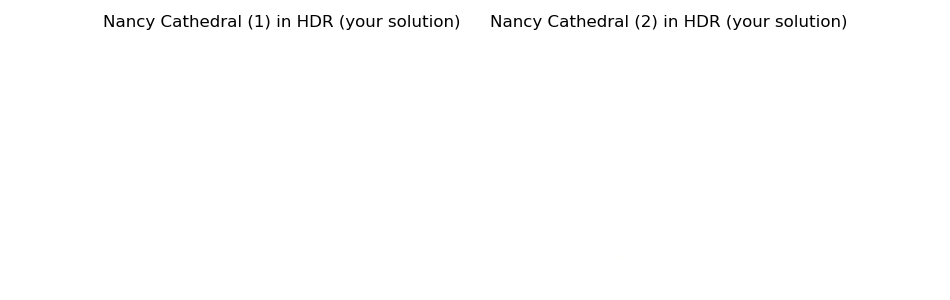

In [2]:
photo1_hdr = helpers.imread_hdr(os.path.join(helpers.dataset_folder, "week1", "hdr", "nancy_cathedral.exr"))
photo2_hdr = helpers.imread_hdr(os.path.join(helpers.dataset_folder, "week1", "hdr", "nancy_cathedral_2.exr"))

helpers.show_images({
    "Nancy Cathedral (1) in HDR (your solution)": photo1_hdr,
    "Nancy Cathedral (2) in HDR (your solution)": photo2_hdr,
}, nrows=1, ncols=2)

### Exercise 7 (1 point)
A naive way of tonemapping is to offset and (linearly) stretch the color channels such that they ranges from 0 to $s$ (similar to contrast stretching). Here, $s$ acts as the scaling factor and allows some part of the image to be clipped ($>1.0$). This ensures that bright highlights remain bright without underexposing the rest of the image.

Implement a tone mapping function that offsets/stretches each of the color channels such that it ranges from 0 to $s$ and find a suitable scaling factor.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
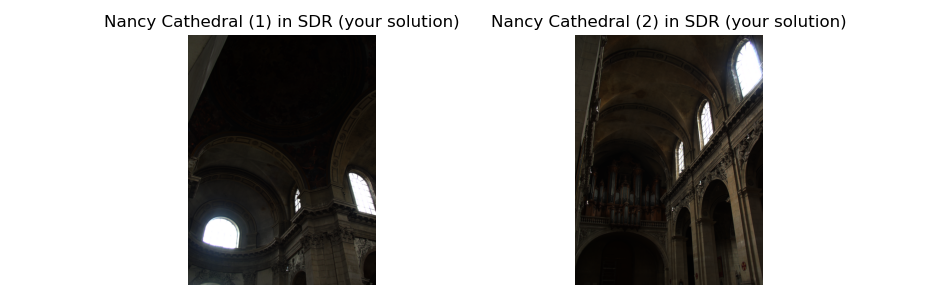

In [3]:
def stretch_color_tonemap(hdr_image, s):
    return np.clip(0 + (s - 0) * (hdr_image - np.min(hdr_image))/(np.max(hdr_image) - np.min(hdr_image)), 0, 1)

photo1_hdr = helpers.imread_hdr(os.path.join(helpers.dataset_folder, "week1", "hdr", "nancy_cathedral.exr"))
photo2_hdr = helpers.imread_hdr(os.path.join(helpers.dataset_folder, "week1", "hdr", "nancy_cathedral_2.exr"))

photo1_sdr = stretch_color_tonemap(photo1_hdr, 200.0)
photo2_sdr = stretch_color_tonemap(photo2_hdr, 200.0)

helpers.show_images({
    "Nancy Cathedral (1) in SDR (your solution)": photo1_sdr,
    "Nancy Cathedral (2) in SDR (your solution)": photo2_sdr,
}, nrows=1, ncols=2)

### Exercise 8 (2 points)
Simply scaling the contrast doesn't work very well for images with large dynamic range because it also compressed the image details. We therefor need a more complex *tonemapping* operator to convert an HDR signal into standard dynamic range which can be displayed by our monitors.

In this exercise you will implement the tonemapping function that was described in the first lecture. In summary, the algorithm consists of the following steps:
 * Compute the intensity of the image ($\text{intensity}=0.35*R+0.45*G+0.2*B$)
 * Separate color from the intensity ($\text{color}=(R,G,B)/\text{intensity}$)
 * Compute the large scale intensity using a bilateral filter (`cv2.bilateralFilter(intensity, -1, 2, 2)`)
 * Compute the layer that stores local details
 * Reduce the contrast of the large scale layer by rescaling it to a range of $0$ to $s$ (same as exercise 7)
 * Combine the modified large scale layer with the detail layer to create a new intensity layer.
 * Finally, combine the intensity- and color layers to create the new image.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
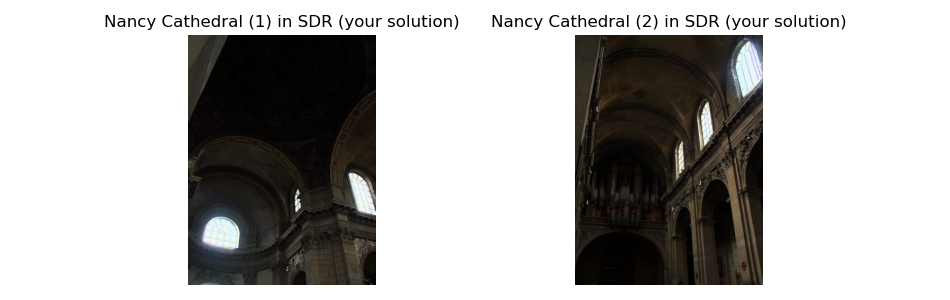

In [4]:
def local_tonemap(hdr_image, s):
    I = 0.35 * hdr_image[:, :, 0] + 0.45 * hdr_image[:, :, 1] + 0.2 * hdr_image[:, :, 2]
    color = hdr_image/I[:, :, None]

    LSI = cv2.bilateralFilter(I, -1, 2, 2)

    details = I/LSI

    LSI_rescaled = stretch_color_tonemap(LSI, s)

    I_new = details * LSI_rescaled

    new_image = color * I_new[:,:,None]
    
    return new_image
    
photo1_hdr = helpers.imread_hdr(os.path.join(helpers.dataset_folder, "week1", "hdr", "nancy_cathedral.exr"))
photo2_hdr = helpers.imread_hdr(os.path.join(helpers.dataset_folder, "week1", "hdr", "nancy_cathedral_2.exr"))

photo1_sdr = local_tonemap(photo1_hdr, 200.0)
photo2_sdr = local_tonemap(photo2_hdr, 200.0)

helpers.show_images({
    "Nancy Cathedral (1) in SDR (your solution)": photo1_sdr,
    "Nancy Cathedral (2) in SDR (your solution)": photo2_sdr,
}, nrows=1, ncols=2)